In [1]:
import pandas as pd
import numpy as np

import requests

from dotenv import load_dotenv
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import fastcore.all as fc

from ta import add_all_ta_features
from ta.utils import dropna

from sklearn.preprocessing import RobustScaler, MinMaxScaler

from pyts.image import GramianAngularField

# data util functions
from data import get_data, p2df, zscore_normalize, minmax_normalize, normalize_, create_window

In [2]:
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer

In [3]:
# FOR THIS WE WILL USE THE POLYGON API
load_dotenv()
POLYGON_API_KEY = os.getenv('POLYGON_API_KEY')

In [4]:
# # load some data, we will use TSLA
data = get_data(POLYGON_API_KEY, ticker="SPY", multiplier=30, timespan="minute", from_="2022-01-09", to="2023-02-10", limit=50000)

In [5]:
# turn our data into a dataframe
df = p2df(data, convert_timestamp=True) # convert timestamp to datetime

# for our GADF we will first add a lot of TA features
# the only features we are interested in are open, high, low, close, volume so lets clear the rest
df = df[['open', 'high', 'low', 'close', 'volume']]
df.head()

# lets drop any na values, there shouldnt be any with polgyon data
df = dropna(df)

# lets now add all the ta features
df = add_all_ta_features(df, open="open", high="high", low="low", close="close", volume="volume", fillna=True)

df

/opt/homebrew/Caskroom/miniforge/base/envs/nlp/lib/python3.9/site-packages/ta/trend.py:780: RuntimeWarning: invalid value encountered in double_scalars
  dip[idx] = 100 * (self._dip[idx] / value)
/opt/homebrew/Caskroom/miniforge/base/envs/nlp/lib/python3.9/site-packages/ta/trend.py:785: RuntimeWarning: invalid value encountered in double_scalars
  din[idx] = 100 * (self._din[idx] / value)


,open,high,low,close,volume,volume_adi,volume_obv,volume_cmf,volume_fi,volume_em,...,momentum_ppo,momentum_ppo_signal,momentum_ppo_hist,momentum_pvo,momentum_pvo_signal,momentum_pvo_hist,momentum_kama,others_dr,others_dlr,others_cr
0,466.500,466.6800,465.850,466.680,15308.0,1.530800e+04,15308.0,1.000000,0.000000e+00,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,466.680000,5.361204,0.000000,0.000000
1,466.740,466.8600,466.220,466.220,5440.0,9.868000e+03,9868.0,0.475612,-2.502400e+03,3235.294118,...,-0.007864,-0.001573,-0.006291,-5.400212,-1.080042,-4.320169,466.556241,-0.098569,-0.098617,-0.098569
2,466.000,466.8000,465.950,466.200,7542.0,6.762471e+03,2326.0,0.239041,-2.166463e+03,-1859.586317,...,-0.014278,-0.004114,-0.010164,-8.731437,-2.610321,-6.121116,466.461493,-0.004290,-0.004290,-0.102854
3,466.240,466.3400,465.720,465.820,5621.0,2.954696e+03,-3295.0,0.087131,-2.162108e+03,-3805.372709,...,-0.025640,-0.008419,-0.017221,-12.741628,-4.636583,-8.105045,466.282514,-0.081510,-0.081543,-0.184280
4,465.950,465.9500,465.330,465.330,5382.0,-2.427304e+03,-8677.0,-0.061774,-2.229976e+03,-4492.753623,...,-0.042634,-0.015262,-0.027372,-16.284945,-6.966255,-9.318690,466.006870,-0.105191,-0.105246,-0.289277
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1837,451.070,452.3078,450.800,451.990,4627305.0,2.949195e+08,22632473.0,-0.157299,-1.760426e+06,-8.182054,...,-0.202634,-0.184152,-0.018483,-0.018201,-27.823990,27.805789,452.983986,0.197295,0.197101,-3.147767
1838,451.985,452.4300,451.565,451.695,2959783.0,2.928494e+08,19672690.0,-0.253813,-1.633671e+06,12.964261,...,-0.211304,-0.189582,-0.021722,0.509943,-22.157204,22.667146,452.788341,-0.065267,-0.065288,-3.210980
1839,451.690,451.7500,450.110,450.350,5265960.0,2.891247e+08,14406730.0,-0.345226,-2.412106e+06,-33.245600,...,-0.239408,-0.199547,-0.039861,7.048939,-16.315975,23.364914,452.301901,-0.297767,-0.298212,-3.499186
1840,450.330,450.5100,449.670,450.430,3067914.0,2.916083e+08,17474644.0,-0.228312,-2.032457e+06,-22.999341,...,-0.257329,-0.211104,-0.046225,6.204162,-11.811948,18.016110,451.966308,0.017764,0.017762,-3.482043


In [6]:
# creating windows 1 month with 1d intervals
window_size = 2
target = df['close'].rolling(window_size).apply(lambda x: (x[-1] - x[0]) / x[0], raw=True).values

In [7]:
pd.Series(target).describe()

count    1841.000000
mean       -0.000016
std         0.002702
min        -0.017204
25%        -0.001072
50%         0.000000
75%         0.001100
max         0.015795
dtype: float64

In [8]:
# lets scale our data, not including our target
scaler = MinMaxScaler(feature_range=(0,1))
scaler = scaler.fit(df.values)
data_normalized = scaler.transform(df.values)

In [9]:
class Data:
    def __init__(self, data, target): self.data, self.target = data, target
    def __len__(self): return len(self.data)
    def __getitem__(self, i): return self.data[i], self.target[i]

In [10]:
data = Data(data_normalized, target)

In [11]:
def create_window(data, start=0, size=28):
    """Create a window of data"""
    x = data.data[start:start+size]
    y = data.target[start:start+size+1]
    return {'data': x, 'target': y[-1]}

In [12]:
time_window = 12
window = create_window(data, start=1, size=time_window)
# create window sliding with stride of 1
windows = [create_window(data, start=i, size=time_window) for i in range(len(data)-time_window)]
len(windows)

1830

In [13]:
# create a split of windows to train and test
train_split = int(len(windows) * 0.8)
train_windows = windows[:train_split]
test_windows = windows[train_split:]

In [14]:
gadf = GramianAngularField(image_size=28, method='difference')

In [15]:
# lets create our CNN dataset class
class CNNDataset(Dataset):
    def __init__(self, windows, transform_fn=gadf, conv3d=False):
        self.conv3d = conv3d
        self.X = [transform_fn.fit_transform(window['data']) for window in windows]
        self.y = [window['target'] for window in windows]

    def __len__(self): return len(self.y)
    def __getitem__(self, idx):
        x = torch.tensor(self.X[idx], dtype=torch.float)
        # reshape for conv3
        if self.conv3d: x = x[None, :, :, :]
        y = torch.tensor(self.y[idx], dtype=torch.float).unsqueeze(0)
        return x, y

In [16]:
from dataclasses import dataclass

In [17]:
@dataclass
class Dls:
    train: DataLoader
    valid: DataLoader

In [18]:
conv3d = True

train_ds = CNNDataset(train_windows, conv3d=conv3d, transform_fn=gadf)
valid_ds = CNNDataset(test_windows, conv3d=conv3d, transform_fn=gadf)

# create our dataloaders
dls = Dls(
    train = DataLoader(train_ds, batch_size=32, shuffle=True),
    valid = DataLoader(valid_ds, batch_size=32, shuffle=False))

xb, yb = next(iter(dls.train))
xb.shape, yb.shape

(torch.Size([32, 1, 12, 28, 28]), torch.Size([32, 1]))

In [19]:
def_device = "mps" if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu'
def_device = 'cpu' if conv3d else def_device

def to_device(data, device=def_device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)): return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [20]:
class Learner:
    """This is our main class that will be responsible to experimenting and training various models. It serves the purpose of being a vehicle to experiment quickly"""
    def __init__(self, model, dls, loss_func, lr, opt_func=optim.SGD):
        """
        model: <PyTorch Model> the model we are going to train
        dls: <Pytorch DataLoader> the dataloaders we are going to use
        loss_func: <Callable> the loss function we are going to use
        lr: <float> the learning rate we are going to use
        opt_func: <PyTorch optimizer (can be custom)> the optimizer we are going to use
        """
        fc.store_attr() # easy method to store all attributes, prevents mistakes

    def one_batch(self):
        """This method is responsible for one batch of training/evaluation"""
        self.xb, self.yb = to_device(self.batch) # move batch to device
        self.preds = self.model(self.xb) # get predictions
        self.loss = self.loss_func(self.preds, self.yb) # calculate loss
        if self.model.training:
            self.loss.backward() # calculate gradients
            self.opt.step() # update weights
            self.opt.zero_grad() # zero gradients
        with torch.no_grad(): self.calc_stats()

    def calc_stats(self):
        """This method is responsible for calculating statistics"""
        n = len(self.xb)
        self.losses.append(self.loss*n)
        self.ns.append(n)
    
    def one_epoch(self, train):
        self.model.training = train # set model to training mode or evaluation mode
        dl = self.dls.train if train else self.dls.valid # get the correct dataloader
        for self.num, self.batch in enumerate(dl): 
            self.one_batch() # call one_batch method, self.batch will be set to the current batch
        n = sum(self.ns)
        print(f"Epoch: {self.epoch+1}", 'train' if self.model.training else 'valid', f"Loss: {sum(self.losses).item()/n}")
    
    def fit(self, n_epochs):
        """Very lightweight fit method, this is the highest level to train a model via the Learner object"""
        self.losses, self.ns = [], []
        self.model.to(def_device) # place model on appropriate device TODO: Allow this to be changed via fit calls if necessary
        self.opt = self.opt_func(self.model.parameters(), lr=self.lr) # create optimizer
        self.n_epochs = n_epochs
        for self.epoch in range(n_epochs):
            self.one_epoch(True) # training
            self.one_epoch(False) # evaluation

In [21]:
class SimpleCNN3D(nn.Module):
    def __init__(self, input_shape, activation=nn.ReLU):
        super(SimpleCNN3D, self).__init__()
        batch_size, channels, depth, height, width = input_shape
        self.conv_layers = nn.Sequential(
            nn.Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1)),
            activation(),
            nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2)),
            nn.Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1)),
            activation(),
            nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2)),
        )
        # calculate the output size of the convolutional layers
        conv_output_size = self._get_conv_output(input_shape)
        self.head = nn.Sequential(
            nn.Flatten(),
            nn.Linear(conv_output_size, 64),
            activation(),
            nn.Linear(64, 1)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.head(x)
        return x

    def _get_conv_output(self, shape):
        batch_size = shape[0]
        input = torch.autograd.Variable(torch.rand(*shape))
        output_feat = self.conv_layers(input)
        n_size = output_feat.data.view(batch_size, -1).size(1)
        return n_size
    
class TinyCNN(nn.Module):
    def __init__(self, input_shape, activation=nn.ReLU):
        super(TinyCNN, self).__init__()
        _, _, depth, height, width = input_shape
        self.conv_layers = nn.Sequential(
            nn.Conv3d(1, 8, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1)),
            activation(),
            nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2)),
            nn.Conv3d(8, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1)),
            activation(),
            nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2)),
        )
        # calculate the output size of the convolutional layers
        self.conv_output_size = self._get_conv_output(input_shape)
        self.head = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.conv_output_size, 16),
            activation(),
            nn.Linear(16, 1)
        )
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.head(x)
        return x

    def _get_conv_output(self, shape):
        batch_size = shape[0]
        input = torch.autograd.Variable(torch.rand(*shape))
        output_feat = self.conv_layers(input)
        n_size = output_feat.data.view(batch_size, -1).size(1)
        return n_size
    
class DeepCNN(nn.Module):
    def __init__(self, input_shape, activation=nn.ReLU):
        super(DeepCNN, self).__init__()
        _, _, depth, height, width = input_shape
        self.conv_layers = nn.Sequential(
            nn.Conv3d(1, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1)),
            activation(),
            nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2)),
            nn.Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1)),
            activation(),
            nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2)),
            nn.Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1)),
            activation(),
            nn.MaxPool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2)),
        )
        # calculate the output size of the convolutional layers
        self.conv_output_size = self._get_conv_output(input_shape)
        self.head = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.conv_output_size, 128),
            activation(),
            nn.Linear(128, 64),
            activation(),
            nn.Linear(64, 1)
        )
    
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.head(x)
        return x

    def _get_conv_output(self, shape):
        batch_size = shape[0]
        input = torch.autograd.Variable(torch.rand(*shape))
        output_feat = self.conv_layers(input)
        n_size = output_feat.data.view(batch_size, -1).size(1)
        return n_size

class TinyTransformer(nn.Module):
    def __init__(self, input_shape, nhead=8, num_layers=6, dropout=0.1):
        super(TinyTransformer, self).__init__()
        _, _, depth, height, width = input_shape
        self.embed_dim = depth * height * width
        self.pos_encoder = nn.Sequential(
            nn.Linear(self.embed_dim, self.embed_dim),
            nn.ReLU(),
        )
        encoder_layers = TransformerEncoderLayer(d_model=self.embed_dim, nhead=nhead, dropout=dropout)
        self.transformer_encoder = TransformerEncoder(encoder_layers, num_layers=num_layers)
        self.head = nn.Sequential(
            nn.Linear(self.embed_dim, 16),
            nn.ReLU(),
            nn.Linear(16, 1)
        )

    def forward(self, x):
        x = x.view(-1, self.embed_dim)
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        x = self.head(x)
        return x


In [24]:
# # create a simple 2d cnn
# simple_cnn = SimpleCNN2D(xb.shape)
# create a simple 3d cnn
simple_cnn = TinyTransformer(xb.shape, nhead=2, num_layers=1, dropout=0.1)

# number of parameters
print(f"Number of parameters: {sum(p.numel() for p in simple_cnn.parameters())}")

Number of parameters: 481334177


In [215]:
# load our model
simple_cnn.load_state_dict(torch.load('simple_cnn_spy_3_tiny.pth'))

<All keys matched successfully>

In [216]:
# Freeze conv_layers
for param in simple_cnn.conv_layers.parameters():
    param.requires_grad = False

# replace the head with a new one
simple_cnn.head = nn.Sequential(
            nn.Flatten(),
            nn.Linear(simple_cnn.conv_output_size, 32),
            nn.GELU(),
            nn.Linear(32, 1)
        )

In [240]:
learn = Learner(simple_cnn, dls, loss_func=nn.MSELoss(), lr=0.01, opt_func=optim.RAdam)

In [241]:
learn.fit(20)

Epoch: 1 train Loss: 0.0031533873146348964
Epoch: 1 valid Loss: 0.002559402080181518
Epoch: 2 train Loss: 0.0014449528078636258
Epoch: 2 valid Loss: 0.001301675546364706
Epoch: 3 train Loss: 0.000934089747003798
Epoch: 3 valid Loss: 0.0008726832210909039
Epoch: 4 train Loss: 0.0006916771889555753
Epoch: 4 valid Loss: 0.0006575852795376804
Epoch: 5 train Loss: 0.0005496581286897642
Epoch: 5 valid Loss: 0.0005280889709139131
Epoch: 6 train Loss: 0.0004567182151660736
Epoch: 6 valid Loss: 0.00044181507576141637
Epoch: 7 train Loss: 0.0003908353386795892
Epoch: 7 valid Loss: 0.00037990178473753264
Epoch: 8 train Loss: 0.0003418561305521382
Epoch: 8 valid Loss: 0.00033350863743349503
Epoch: 9 train Loss: 0.00030389124637685244
Epoch: 9 valid Loss: 0.00029734656097097115
Epoch: 10 train Loss: 0.0002736888948034068
Epoch: 10 valid Loss: 0.00026837799718471174
Epoch: 11 train Loss: 0.00024897225639931565
Epoch: 11 valid Loss: 0.0002446268899370886
Epoch: 12 train Loss: 0.00022843867371984795
E

In [245]:
# let's run some predictions, we will plot the predictions and the actual values
def plot_preds(preds, yb):
    plt.plot(preds, label="preds")
    plt.plot(yb, label="actual")
    plt.legend()

def predict_plot(xb, yb, model):
    # move to device
    xb, yb = to_device(xb), to_device(yb)
    if isinstance(model, nn.Module): model = to_device(model)

    # get predictions
    preds = model(xb)

    # plot predictions
    with torch.no_grad(): plot_preds(preds.squeeze().detach().cpu().numpy(), yb.squeeze().detach().cpu().numpy())

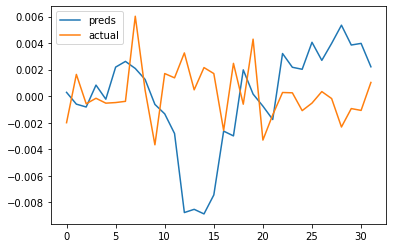

In [246]:
# plot predictions
xb, yb = next(iter(dls.valid))
predict_plot(xb, yb, simple_cnn)

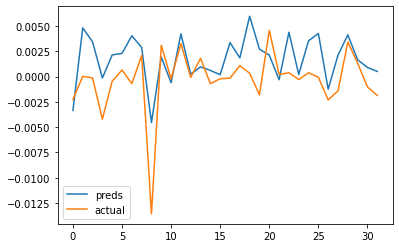

In [247]:
# plot predictions
xb, yb = next(iter(dls.train))
predict_plot(xb, yb, simple_cnn)